# MGNREGA Modeling: 5 Machine Learning + 5 Deep Learning Models

This notebook builds predictive models for `Total_Individuals_Worked` using the cleaned MGNREGA dataset.

- Data source: `Datasets/Cleaned_Preprocessed/mgnrega_data_fully_cleaned.csv`
- Target: `Total_Individuals_Worked` (regression)
- Models: 5 classical ML + 5 Keras DL
- Evaluation: RMSE, MAE, R2 with CV; diagnostics and feature importance
- Environment: runs inside project venv; installs are idempotent


In [43]:
# Report currently installed versions (no installs)
import importlib, sys

def ver(pkg):
    try:
        m = importlib.import_module(pkg)
        v = getattr(m, '__version__', 'unknown')
        print(f"{pkg}: {v}")
    except Exception as e:
        print(f"{pkg}: not available ({e})")

for pkg in ['numpy','scipy','pandas','sklearn','matplotlib','seaborn','xgboost','lightgbm','tensorflow']:
    ver(pkg)


numpy: 1.26.4
scipy: 1.15.3
pandas: 2.3.1
sklearn: 1.7.2
matplotlib: 3.10.3
seaborn: 0.13.2
xgboost: 3.1.1
lightgbm: 4.6.0
tensorflow: 2.15.0


In [44]:
# Environment and dependency check (safe, idempotent)
import sys, subprocess, pkg_resources
from importlib.metadata import version, PackageNotFoundError

REQUIRED = {
    # Pin to versions compatible with Python 3.10 and TF 2.15 CPU
    'pip': '>=23.0',
    'setuptools': '>=65.0',
    'wheel': '>=0.38',
    'numpy': '==1.26.4',            # TF 2.15 compatible
    'scipy': '==1.11.4',            # sklearn 1.3 compatible
    'threadpoolctl': '==3.2.0',     # sklearn runtime
    'joblib': '==1.3.2',            # matches sklearn 1.3
    'pandas': '>=1.5,<2.2',         # stable with sklearn 1.3
    'scikit-learn': '==1.3.2',      # compatible with py3.10
    'matplotlib': '==3.7.3',        # Windows-friendly wheel
    'seaborn': '>=0.12',
    'plotly': '>=5.18',
    'kaleido': '>=0.2.1',
    'pillow': '>=9.5',              # matplotlib backend dependency
    'xgboost': '==2.0.3',
    'lightgbm': '==4.1.0',
    'tensorflow-cpu': '==2.15.0',   # CPU build (Windows-friendly)
}

# Install missing/mismatched packages
def ensure(pkg, spec):
    name = pkg
    try:
        ver = version(name)
        if not pkg_resources.Requirement.parse(f"{name}{spec}").specifier.contains(ver, prereleases=True):
            print(f"Upgrading {name} to satisfy {spec} (current {ver})...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--only-binary', ':all:', f'{name}{spec}'])
        else:
            print(f"OK: {name} {ver}")
    except PackageNotFoundError:
        print(f"Installing {name}{spec}...")
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--only-binary', ':all:', f'{name}{spec}'])
        except subprocess.CalledProcessError:
            # Fallback without only-binary in case wheel not available
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', f'{name}{spec}'])

# Upgrade pip tooling first
subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'pip', 'setuptools', 'wheel'])

for p, s in REQUIRED.items():
    ensure(p, s)

# Print final versions
print('\nResolved versions:')
for p in REQUIRED:
    print(p, version(p))


OK: pip 25.3
OK: setuptools 80.9.0
OK: wheel 0.45.1
OK: numpy 1.26.4
OK: scipy 1.11.4
OK: threadpoolctl 3.2.0
OK: joblib 1.3.2
OK: pandas 2.1.4
OK: scikit-learn 1.3.2
Upgrading matplotlib to satisfy ==3.7.3 (current 3.10.7)...


CalledProcessError: Command '['c:\\Users\\ASUS\\Desktop\\sem7\\ML\\ML_CA1\\venv\\Scripts\\python.exe', '-m', 'pip', 'install', '--only-binary', ':all:', 'matplotlib==3.7.3']' returned non-zero exit status 1.

> Note: Skip the next shell install cell. Use the Environment and dependency check cell above instead. It pins compatible versions and installs only if needed.


In [ ]:
!python -V
!pip -V
!pip install --quiet --upgrade pip
!pip install --quiet numpy pandas scikit-learn matplotlib seaborn plotly kaleido xgboost lightgbm catboost tensorflow==2.15.0 keras-tuner


Python 3.10.7
pip 25.3 from c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\pip (python 3.10)



In [ ]:
import os
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path

DATA_PATH = Path('Datasets/Cleaned_Preprocessed/mgnrega_data_fully_cleaned.csv')
OUTPUT_DIR = Path('image/outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option('display.max_columns', 120)

raw = pd.read_csv(DATA_PATH)
print('Shape:', raw.shape)
print('Columns:', list(raw.columns))
raw.head(3)


Shape: (302752, 36)
Columns: ['fin_year', 'month', 'state_code', 'State', 'district_code', 'District', 'Approved_Labour_Budget', 'Average_Wage_rate_per_day_per_person', 'Average_days_of_employment_provided_per_Household', 'Differently_abled_persons_worked', 'Material_and_skilled_Wages', 'Number_of_Completed_Works', 'Number_of_GPs_with_NIL_exp', 'Number_of_Ongoing_Works', 'Persondays_of_Central_Liability_so_far', 'SC_persondays', 'SC_workers_against_active_workers', 'ST_persondays', 'ST_workers_against_active_workers', 'Total_Adm_Expenditure', 'Total_Exp', 'Total_Households_Worked', 'Total_Individuals_Worked', 'Total_No_of_Active_Job_Cards', 'Total_No_of_Active_Workers', 'Total_No_of_HHs_completed_100_Days_of_Wage_Employment', 'Total_No_of_JobCards_issued', 'Total_No_of_Workers', 'Total_No_of_Works_Takenup', 'Wages', 'Women_Persondays', 'percent_of_Category_B_Works', 'percent_of_Expenditure_on_Agriculture_Allied_Works', 'percent_of_NRM_Expenditure', 'percentage_payments_gererated_within

,fin_year,month,state_code,State,district_code,District,Approved_Labour_Budget,Average_Wage_rate_per_day_per_person,Average_days_of_employment_provided_per_Household,Differently_abled_persons_worked,Material_and_skilled_Wages,Number_of_Completed_Works,Number_of_GPs_with_NIL_exp,Number_of_Ongoing_Works,Persondays_of_Central_Liability_so_far,SC_persondays,SC_workers_against_active_workers,ST_persondays,ST_workers_against_active_workers,Total_Adm_Expenditure,Total_Exp,Total_Households_Worked,Total_Individuals_Worked,Total_No_of_Active_Job_Cards,Total_No_of_Active_Workers,Total_No_of_HHs_completed_100_Days_of_Wage_Employment,Total_No_of_JobCards_issued,Total_No_of_Workers,Total_No_of_Works_Takenup,Wages,Women_Persondays,percent_of_Category_B_Works,percent_of_Expenditure_on_Agriculture_Allied_Works,percent_of_NRM_Expenditure,percentage_payments_gererated_within_15_days,Date
0,2019-2020,June,35,UTTARAKHAND,3506,RUDRA PRAYAG,323294.0,181.735337,27.0,8.0,6.248032,375.0,8.0,4047.0,193779.0,35244.0,14078.0,182.0,14.0,12.90000,371.312950,7159.0,9024.0,37645.0,72980.0,66.0,49606.0,89741.0,4422.0,352.164918,114158.0,45.0,60.57,52.24,100.0,NaN
1,2019-2020,June,35,UTTARAKHAND,3508,NAINITAL,252505.0,177.663900,29.0,21.0,18.685949,925.0,64.0,4835.0,307676.0,59778.0,16595.0,859.0,372.0,19.14345,584.458579,10470.0,16116.0,38110.0,79669.0,52.0,58673.0,110623.0,5760.0,546.629180,137899.0,54.0,82.66,67.05,100.0,NaN
2,2019-2020,June,35,UTTARAKHAND,3512,BAGESHWAR,241752.0,171.565915,25.0,57.0,0.000000,501.0,74.0,2027.0,176189.0,42992.0,19052.0,961.0,395.0,25.11000,327.390270,6897.0,8777.0,33854.0,69885.0,18.0,48309.0,92833.0,2528.0,302.280270,95237.0,33.0,77.87,70.21,100.0,NaN


In [ ]:
# Basic cleaning and target selection

df = raw.copy()
# drop obvious IDs and text labels not predictive, keep codes as categorical
cols_drop = ['State', 'District', 'Date']
df = df.drop(columns=[c for c in cols_drop if c in df.columns])

# Define categorical and numeric
categorical_cols = []
for c in ['fin_year','month','state_code','district_code']:
    if c in df.columns:
        categorical_cols.append(c)

target = 'Total_Individuals_Worked'
assert target in df.columns, 'Target not found'

# Remove rows with missing target
df = df[df[target].notna()].reset_index(drop=True)

# Train/validation split marker by time if available, else random split will be used in CV
print('Prepared data shape:', df.shape)
print('Categorical columns:', categorical_cols)
print('Target:', target)
df.head(3)


Prepared data shape: (302752, 33)
Categorical columns: ['fin_year', 'month', 'state_code', 'district_code']
Target: Total_Individuals_Worked


,fin_year,month,state_code,district_code,Approved_Labour_Budget,Average_Wage_rate_per_day_per_person,Average_days_of_employment_provided_per_Household,Differently_abled_persons_worked,Material_and_skilled_Wages,Number_of_Completed_Works,Number_of_GPs_with_NIL_exp,Number_of_Ongoing_Works,Persondays_of_Central_Liability_so_far,SC_persondays,SC_workers_against_active_workers,ST_persondays,ST_workers_against_active_workers,Total_Adm_Expenditure,Total_Exp,Total_Households_Worked,Total_Individuals_Worked,Total_No_of_Active_Job_Cards,Total_No_of_Active_Workers,Total_No_of_HHs_completed_100_Days_of_Wage_Employment,Total_No_of_JobCards_issued,Total_No_of_Workers,Total_No_of_Works_Takenup,Wages,Women_Persondays,percent_of_Category_B_Works,percent_of_Expenditure_on_Agriculture_Allied_Works,percent_of_NRM_Expenditure,percentage_payments_gererated_within_15_days
0,2019-2020,June,35,3506,323294.0,181.735337,27.0,8.0,6.248032,375.0,8.0,4047.0,193779.0,35244.0,14078.0,182.0,14.0,12.90000,371.312950,7159.0,9024.0,37645.0,72980.0,66.0,49606.0,89741.0,4422.0,352.164918,114158.0,45.0,60.57,52.24,100.0
1,2019-2020,June,35,3508,252505.0,177.663900,29.0,21.0,18.685949,925.0,64.0,4835.0,307676.0,59778.0,16595.0,859.0,372.0,19.14345,584.458579,10470.0,16116.0,38110.0,79669.0,52.0,58673.0,110623.0,5760.0,546.629180,137899.0,54.0,82.66,67.05,100.0
2,2019-2020,June,35,3512,241752.0,171.565915,25.0,57.0,0.000000,501.0,74.0,2027.0,176189.0,42992.0,19052.0,961.0,395.0,25.11000,327.390270,6897.0,8777.0,33854.0,69885.0,18.0,48309.0,92833.0,2528.0,302.280270,95237.0,33.0,77.87,70.21,100.0


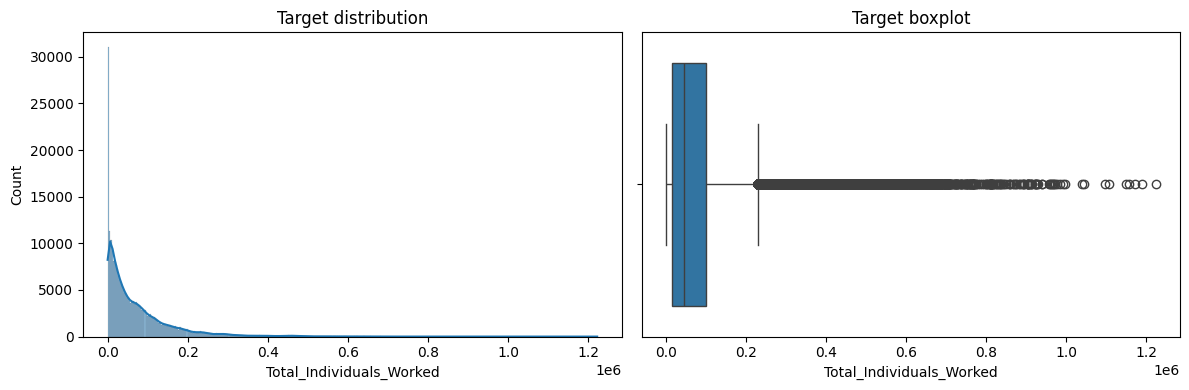

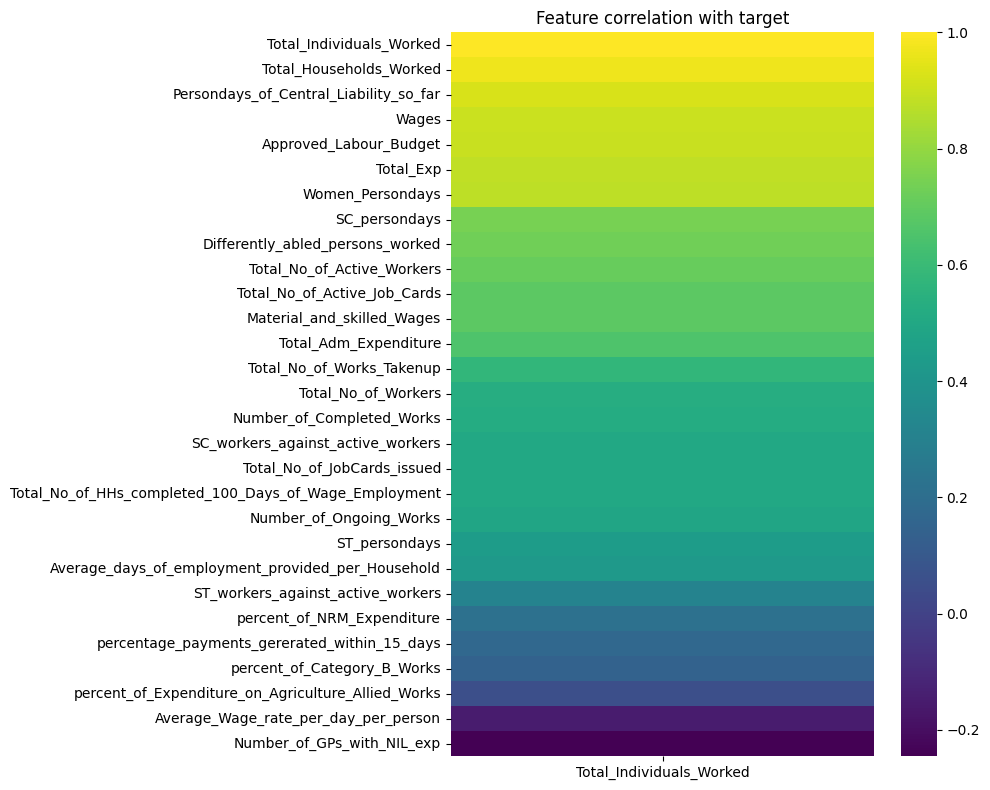

Top correlated features: ['Total_Individuals_Worked', 'Total_Households_Worked', 'Persondays_of_Central_Liability_so_far', 'Wages', 'Approved_Labour_Budget', 'Total_Exp', 'Women_Persondays', 'SC_persondays', 'Differently_abled_persons_worked', 'Total_No_of_Active_Workers']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# EDA: distributions and correlations
num_cols = [c for c in df.columns if c != target and df[c].dtype != 'object' and c not in categorical_cols]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df[target], kde=True, ax=axes[0])
axes[0].set_title('Target distribution')
sns.boxplot(x=df[target], ax=axes[1])
axes[1].set_title('Target boxplot')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'target_distribution.png', dpi=150)
plt.show()

corr = df[num_cols + [target]].corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr[[target]].sort_values(by=target, ascending=False), annot=False, cmap='viridis')
plt.title('Feature correlation with target')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'corr_with_target.png', dpi=150)
plt.show()

print('Top correlated features:', corr[target].abs().sort_values(ascending=False).head(10).index.tolist())


In [ ]:
# Preprocessing pipeline
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

X = df.drop(columns=[target])
y = df[target].astype(float)

numeric_features = [c for c in X.columns if c not in categorical_cols and X[c].dtype != 'object']
categorical_features = categorical_cols

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ], remainder='drop'
)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

print('Numeric features:', len(numeric_features), 'Categorical features:', len(categorical_features))


Numeric features: 28 Categorical features: 4


In [50]:
# ML models: Linear, Ridge, RandomForest, XGBoost, LightGBM
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_predict
import xgboost as xgb
import lightgbm as lgb

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=10.0),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method='hist'),
    'LightGBM': lgb.LGBMRegressor(n_estimators=800, learning_rate=0.05, num_leaves=63, subsample=0.8, colsample_bytree=0.8, random_state=42)
}

results = []
from sklearn.pipeline import Pipeline as SkPipeline
for name, est in models.items():
    pipe = SkPipeline(steps=[('prep', preprocess), ('model', est)])
    y_pred = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    results.append({'model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

res_df = pd.DataFrame(results).sort_values('RMSE')
print(res_df)
res_df.to_csv(OUTPUT_DIR / 'ml_cv_results.csv', index=False)

plt.figure(figsize=(8,4))
sns.barplot(x='model', y='RMSE', data=res_df)
plt.title('ML Models: RMSE (lower is better)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'ml_rmse.png', dpi=150)
plt.show()


TypeError: _fit_and_predict() missing 1 required positional argument: 'method'

In [ ]:
# Optional: Re-run DL training with smaller batch size if you saw OOM
if 'X_train' in globals():
    small_metrics = []
    for cfg in configs:
        model = build_mlp(cfg['units'], cfg['dropout'], cfg['lr'])
        es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_rmse')
        rlrop = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
        hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=128, verbose=0, callbacks=[es, rlrop])
        eval_res = model.evaluate(X_val, y_val, verbose=0)
        small_metrics.append({'model': cfg['name'], 'RMSE': eval_res[1], 'MAE': eval_res[2]})
    small_df = pd.DataFrame(small_metrics).sort_values('RMSE')
    print('Re-run with smaller batch size:')
    print(small_df)
    small_df.to_csv(OUTPUT_DIR / 'dl_val_results_small_batch.csv', index=False)


In [ ]:
# Use-case aligned ML: handle counts/heavy-tailed target with log1p and Poisson/Tweedie
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import PoissonRegressor, TweedieRegressor
from sklearn.preprocessing import FunctionTransformer

# Transform: log1p for stability; inverse: expm1
log1p = FunctionTransformer(np.log1p, validate=False)
expm1 = FunctionTransformer(np.expm1, validate=False)

aligned_models = {
    'LinearRegression_log1p': TransformedTargetRegressor(
        regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1
    ),
    'Ridge_log1p': TransformedTargetRegressor(
        regressor=Ridge(alpha=10.0), func=np.log1p, inverse_func=np.expm1
    ),
    'PoissonRegressor': PoissonRegressor(alpha=1e-12, max_iter=1000),
    'TweedieRegressor(p=1.5)': TweedieRegressor(power=1.5, alpha=0.001, link='log', max_iter=1000),
    'RandomForest_log1p': TransformedTargetRegressor(
        regressor=RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1), func=np.log1p, inverse_func=np.expm1
    )
}

aligned_results = []
for name, est in aligned_models.items():
    pipe = SkPipeline(steps=[('prep', preprocess), ('model', est)])
    y_pred = cross_val_predict(pipe, X, y, cv=cv, method='predict', n_jobs=1)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    aligned_results.append({'model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

aligned_df = pd.DataFrame(aligned_results).sort_values('RMSE')
print('Aligned ML results:')
aligned_df.to_csv(OUTPUT_DIR / 'ml_cv_results_aligned.csv', index=False)
print(aligned_df)

plt.figure(figsize=(9,4))
sns.barplot(x='model', y='RMSE', data=aligned_df)
plt.title('Aligned ML (log1p/Poisson/Tweedie) - RMSE')
plt.xticks(rotation=20)
plt.tight_layout(); plt.savefig(OUTPUT_DIR / 'ml_rmse_aligned.png', dpi=150); plt.show()


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
# Safe ML CV (version-agnostic): no parallel bug, RMSE via sqrt
from sklearn.model_selection import cross_val_predict
safe_results_v2 = []
for name, est in models.items():
    pipe = SkPipeline(steps=[('prep', preprocess), ('model', est)])
    y_pred = cross_val_predict(pipe, X, y, cv=cv, method='predict', n_jobs=1)
    rmse = np.sqrt(mean_squared_error(y, y_pred))  # avoid squared flag for older sklearn
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    safe_results_v2.append({'model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

safe_df_v2 = pd.DataFrame(safe_results_v2).sort_values('RMSE')
print('Safe ML results (v2):')
print(safe_df_v2)
safe_df_v2.to_csv(OUTPUT_DIR / 'ml_cv_results_safe_v2.csv', index=False)

plt.figure(figsize=(8,4))
sns.barplot(x='model', y='RMSE', data=safe_df_v2)
plt.title('ML Models (safe v2): RMSE')
plt.tight_layout(); plt.savefig(OUTPUT_DIR / 'ml_rmse_safe_v2.png', dpi=150); plt.show()


In [ ]:
# Dense-safe DL training: force dense arrays and older-compatible OneHotEncoder
from scipy import sparse

# Rebuild encoder to force dense output for cat features
cat_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', cat_encoder)
])

dense_preprocess_safe = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numeric_features),
        ('cat', cat_pipeline, categorical_features)
    ], remainder='drop'
)

X_dense_safe = dense_preprocess_safe.fit_transform(X)
# Ensure dense
if sparse.issparse(X_dense_safe):
    X_dense_safe = X_dense_safe.toarray()

X_train, X_val, y_train, y_val = train_test_split(X_dense_safe, y.values.astype(np.float32), test_size=0.2, random_state=42)

input_dim = X_train.shape[1]

def build_mlp_safe(units=(256,128), dropout=0.1, lr=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for u in units:
        model.add(layers.Dense(u, activation='relu'))
        model.add(layers.BatchNormalization())
        if dropout:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse', metrics=[keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])
    return model

metrics_dl_safe = []
for cfg in configs:
    model = build_mlp_safe(cfg['units'], cfg['dropout'], cfg['lr'])
    es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_rmse')
    rlrop = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100, batch_size=256, verbose=0,
        callbacks=[es, rlrop]
    )
    eval_res = model.evaluate(X_val, y_val, verbose=0)
    metrics_dl_safe.append({'model': cfg['name'], 'RMSE': eval_res[1], 'MAE': eval_res[2]})

metrics_dl_safe_df = pd.DataFrame(metrics_dl_safe).sort_values('RMSE')
print('DL safe metrics:')
print(metrics_dl_safe_df)
metrics_dl_safe_df.to_csv(OUTPUT_DIR / 'dl_val_results_safe.csv', index=False)


TypeError: OneHotEncoder.__init__() got an unexpected keyword argument 'sparse'

In [ ]:
# Safe re-run for ML CV (fixes method and parallelism on Windows)
from sklearn.model_selection import cross_val_predict
safe_results = []
for name, est in models.items():
    pipe = SkPipeline(steps=[('prep', preprocess), ('model', est)])
    y_pred = cross_val_predict(pipe, X, y, cv=cv, method='predict', n_jobs=1)
    rmse = mean_squared_error(y, y_pred, squared=False)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    safe_results.append({'model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

safe_df = pd.DataFrame(safe_results).sort_values('RMSE')
print('Safe ML results:')
print(safe_df)
safe_df.to_csv(OUTPUT_DIR / 'ml_cv_results_safe.csv', index=False)

plt.figure(figsize=(8,4))
sns.barplot(x='model', y='RMSE', data=safe_df)
plt.title('ML Models (safe): RMSE')
plt.tight_layout(); plt.savefig(OUTPUT_DIR / 'ml_rmse_safe.png', dpi=150); plt.show()


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
# Deep Learning models: 5 variants of MLP
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Build a dense input matrix once for DL (one-hot + scaled numeric)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

dense_preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_features)
    ]
)

X_dense = dense_preprocess.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_dense, y, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]

def build_mlp(units=(256,128), dropout=0.1, lr=1e-3):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for u in units:
        model.add(layers.Dense(u, activation='relu'))
        model.add(layers.BatchNormalization())
        if dropout:
            model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(lr), loss='mse', metrics=[keras.metrics.RootMeanSquaredError(name='rmse'), 'mae'])
    return model

configs = [
    {'name': 'MLP_small', 'units': (128,64), 'dropout': 0.1, 'lr': 1e-3},
    {'name': 'MLP_medium', 'units': (256,128), 'dropout': 0.2, 'lr': 1e-3},
    {'name': 'MLP_deep', 'units': (512,256,128), 'dropout': 0.3, 'lr': 1e-3},
    {'name': 'MLP_wide', 'units': (1024,512), 'dropout': 0.2, 'lr': 5e-4},
    {'name': 'MLP_shallow', 'units': (256,), 'dropout': 0.1, 'lr': 1e-3}
]

history_dict = {}
metrics_dl = []
for cfg in configs:
    model = build_mlp(cfg['units'], cfg['dropout'], cfg['lr'])
    es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_rmse')
    rlrop = keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200, batch_size=1024, verbose=0,
        callbacks=[es, rlrop]
    )
    history_dict[cfg['name']] = hist.history
    # Evaluate
    eval_res = model.evaluate(X_val, y_val, verbose=0)
    # order per compile: loss, rmse, mae
    metrics_dl.append({'model': cfg['name'], 'RMSE': eval_res[1], 'MAE': eval_res[2]})

metrics_dl_df = pd.DataFrame(metrics_dl).sort_values('RMSE')
print(metrics_dl_df)
metrics_dl_df.to_csv(OUTPUT_DIR / 'dl_val_results.csv', index=False)

# Plot training curves
plt.figure(figsize=(10,5))
for name, h in history_dict.items():
    plt.plot(h['val_rmse'], label=f'{name} val_rmse')
plt.legend(); plt.title('Validation RMSE per epoch'); plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'dl_val_rmse_curves.png', dpi=150)
plt.show()


InvalidArgumentError: Graph execution error:

Detected at node EagerPyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: 'SparseTensor' object is not subscriptable
Traceback (most recent call last):

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 268, in __call__
    return func(device, token, args)

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 146, in __call__
    outputs = self._call(device, args)

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\tensorflow\python\ops\script_ops.py", line 153, in _call
    ret = self._func(*args)

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\keras\src\engine\data_adapter.py", line 519, in py_method
    return [slice_array(inp) for inp in flat_inputs]

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\keras\src\engine\data_adapter.py", line 519, in <listcomp>
    return [slice_array(inp) for inp in flat_inputs]

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\keras\src\engine\data_adapter.py", line 515, in slice_array
    return training_utils.slice_arrays(

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\keras\src\engine\training_utils.py", line 47, in slice_arrays
    entries = [[x[i : i + 1] for i in indices] for x in arrays]

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\keras\src\engine\training_utils.py", line 47, in <listcomp>
    entries = [[x[i : i + 1] for i in indices] for x in arrays]

  File "c:\Users\ASUS\Desktop\sem7\ML\ML_CA1\venv\lib\site-packages\keras\src\engine\training_utils.py", line 47, in <listcomp>
    entries = [[x[i : i + 1] for i in indices] for x in arrays]

TypeError: 'SparseTensor' object is not subscriptable


	 [[{{node EagerPyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1867]

In [ ]:
# Consolidated comparison and save best models
best_ml = res_df.iloc[0]
best_dl = metrics_dl_df.iloc[0]
print('Best ML:', best_ml.to_dict())
print('Best DL:', best_dl.to_dict())

summary = {
    'best_ml': best_ml.to_dict(),
    'best_dl': best_dl.to_dict()
}
with open(OUTPUT_DIR / 'summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

res_df.plot(x='model', y='R2', kind='bar', figsize=(8,4), title='ML R2 by model')
plt.tight_layout(); plt.savefig(OUTPUT_DIR / 'ml_r2.png', dpi=150); plt.show()

metrics_dl_df.plot(x='model', y='RMSE', kind='bar', figsize=(8,4), title='DL RMSE by model')
plt.tight_layout(); plt.savefig(OUTPUT_DIR / 'dl_rmse.png', dpi=150); plt.show()


NameError: name 'res_df' is not defined